## Project 2 

### 0. Loading libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE, mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

### 1. Data preprocessing

In [ ]:
# loading X_train
X_train = pd.read_csv("../Project2/x_train.txt", sep = r"\s+", header = None)
print("X_train shape:", X_train.shape)
print(X_train.iloc[:5, :20]) # first 5 rows, 20 columns

# loading y_train 
y_train = pd.read_csv("../Project2/y_train.txt", sep = r"\s+", header = None).iloc[:, 0]
print("y_train shape:", y_train.shape)
print(y_train.head(20)) # first 20 records

# loading X_test
X_test = pd.read_csv("../Project2/x_test.txt", sep = r"\s+", header = None)
print("X_test shape:", X_test.shape)
print(X_test.iloc[:5, :20]) # first 5 rows, 20 columns

X_train shape: (5000, 500)
          0          1          2          3          4          5   \
0  20.454647  16.739345  39.811892  24.955468  27.088535  17.116793   
1  16.175225  10.483281  27.471017  18.509824  19.045353  15.039082   
2  10.577212  10.795115  24.621388  17.264747  14.221610   8.754692   
3  26.299206  13.471215  51.725934  40.786947  26.052414  33.200702   
4  23.193955  20.037969  37.780290  28.983748  25.510508  15.970348   

          6          7          8          9         10        11        12  \
0  25.166957  23.364508  17.223886  18.339175 -1.703605  0.195336 -0.255031   
1  21.354915  15.790575  13.912508  13.772518 -0.663188 -0.617684 -0.325401   
2  18.399259  11.358798  15.432650  14.842153  1.407465  0.481415 -1.128476   
3  51.014330  27.685009  33.107991  25.359457  0.251941  0.071661  1.135213   
4  27.930757  20.707354  25.341768  27.118987  1.298867 -1.399697 -1.437570   

         13        14        15        16        17        18        19

In [5]:
# check for missing values
print("Total missing values in X_train:", X_train.isna().sum().sum())

# y_train distribution
print(y_train.value_counts(), "\nProportion positive:", y_train.mean())

# summary statistics
stats = X_train.describe().T
stats["skew"] = X_train.skew()
print(stats.head(10))  # first 10 features

# top 10 feature–target correlations
corr = X_train.corrwith(y_train)
corr_df = corr.abs().sort_values(ascending=False).head(10)
print(corr_df)

Total missing values in X_train: 0
0
0    2557
1    2443
Name: count, dtype: int64 
Proportion positive: 0.4886
    count       mean       std       min        25%        50%        75%  \
0  5000.0  15.560411  4.327898  3.455568  12.504754  15.112805  18.283206   
1  5000.0  12.650449  3.783868  3.012807   9.929310  12.233362  15.015602   
2  5000.0  27.750084  6.946855  9.361016  22.814920  27.110561  32.077128   
3  5000.0  18.796808  4.931891  6.257807  15.239951  18.405284  21.816898   
4  5000.0  19.071302  5.241326  5.317511  15.294200  18.532972  22.257737   
5  5000.0  11.820110  3.648601  1.941863   9.165871  11.516377  14.043634   
6  5000.0  19.365360  5.316096  4.675356  15.672949  18.795116  22.582849   
7  5000.0  15.602632  4.435020  3.807933  12.457874  15.198056  18.346160   
8  5000.0  14.163618  4.450855  1.269238  10.986306  13.749097  16.865485   
9  5000.0  15.989661  4.793635  4.262201  12.551421  15.374299  18.929673   

         max      skew  
0  33.290878  0

In [ ]:

# 1. Imputing any missing values with the median (you saw there are none today, but this guards if ever derive new features that have NaNs
# 2. Scaling every feature to zero mean/unit variance
# 3. Dropping any feature that is constant (variance < 0.01)


preprocessing = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("scaler",  StandardScaler()),
    ("vthresh", VarianceThreshold(threshold = 0.01)),
])

# fit/transform on train, transform on test
X_train_p = preprocessing.fit_transform(X_train)
X_test_p  = preprocessing.transform(X_test)

print("After minimal preprocessing:")
print("X_train:", X_train.shape, "→", X_train_p.shape)
print("X_test: ", X_test.shape,  "→", X_test_p.shape)

After minimal preprocessing:
X_train: (5000, 500) → (5000, 500)
X_test:  (5000, 500) → (5000, 500)


Number of features in each cluster:
cluster
0    292
1     40
2     60
3    108
Name: count, dtype: int64

Middles of clusters (skew, kurtosis):
       skew  kurtosis
0  0.004026 -0.406334
1  2.069515  6.632375
2  1.910502  5.126956
3  0.882281  1.222596


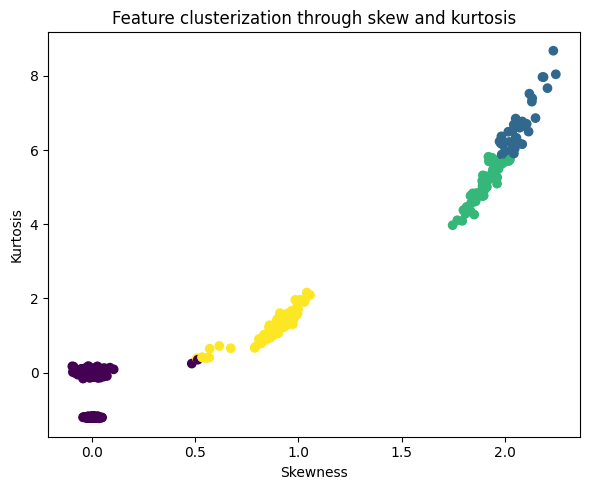

In [ ]:
X_train = pd.read_csv("../Project2/x_train.txt", sep = r"\s+", header=None)

# skewness, kurtosis
skews = X_train.skew()
kurts = X_train.kurtosis()

dist_df = pd.DataFrame({"skew": skews, "kurtosis": kurts})

# K-means for 4 clusters 
kmeans = KMeans(n_clusters = 4, random_state = 33).fit(dist_df)
dist_df["cluster"] = kmeans.labels_

# how many features in each cluster
counts = dist_df["cluster"].value_counts().sort_index()
print("Number of features in each cluster:")
print(counts)

# middles of clusters
centers = pd.DataFrame(kmeans.cluster_centers_, columns = ["skew", "kurtosis"])
print("\nMiddles of clusters (skew, kurtosis):")
print(centers)

plt.figure(figsize = (6, 5))
plt.scatter(dist_df["skew"], dist_df["kurtosis"], c = dist_df["cluster"])
plt.title("Feature clusterization through skew and kurtosis")
plt.xlabel("Skewness")
plt.ylabel("Kurtosis")
plt.tight_layout()
plt.show()

In [8]:
dist_df = pd.DataFrame({"skew": X_train.skew(), "kurtosis": X_train.kurtosis()})

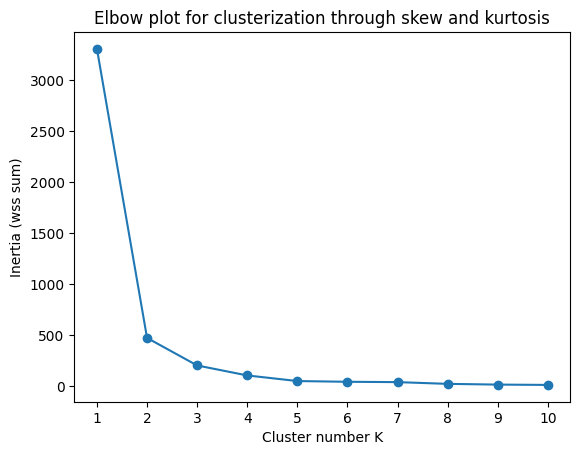

In [ ]:
inertia = []
Ks = range(1, 11)
for k in Ks:
    km = KMeans(n_clusters = k, random_state = 0).fit(dist_df)
    inertia.append(km.inertia_)

plt.plot(Ks, inertia, marker = 'o')
plt.xlabel("Cluster number K")
plt.ylabel("Inertia (wss sum)")
plt.title("Elbow plot for clusterization through skew and kurtosis")
plt.xticks(Ks)
plt.show()

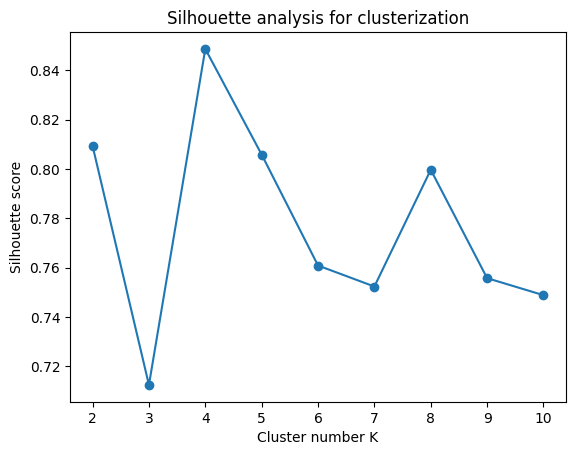

In [ ]:
sil_scores = []
Ks = range(2, 11)
for k in Ks:
    km = KMeans(n_clusters = k, random_state = 0).fit(dist_df)
    sil_scores.append(silhouette_score(dist_df, km.labels_))

plt.plot(Ks, sil_scores, marker = 'o')
plt.xlabel("Cluster number K")
plt.ylabel("Silhouette score")
plt.title("Silhouette analysis for clusterization")
plt.xticks(Ks)
plt.show()

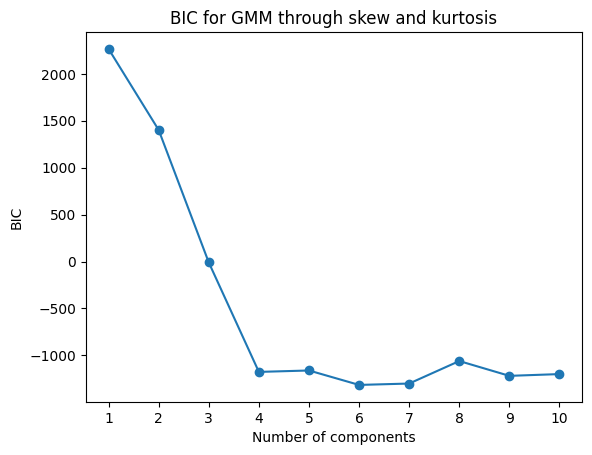

In [ ]:
bics = []
Ks = range(1, 11)
for k in Ks:
    gm = GaussianMixture(n_components = k, random_state=0).fit(dist_df)
    bics.append(gm.bic(dist_df))

plt.plot(Ks, bics, marker = 'o')
plt.xlabel("Number of components")
plt.ylabel("BIC")
plt.title("BIC for GMM through skew and kurtosis")
plt.xticks(Ks)
plt.show()

### 2. Training

In [20]:
"""
X_train = pd.read_csv("../Project2/x_train.txt", sep=r"\s+", header=None)
y_train = pd.read_csv("../Project2/y_train.txt", sep=r"\s+", header=None).iloc[:,0]
X_test  = pd.read_csv("../Project2/x_test.txt",  sep=r"\s+", header=None)
"""

# here, we assume uniform treatment for simplicity. That no cluster-based log transforms(we can load dist_df['cluster'] to include cluster division)
preprocessing = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("scaler",  StandardScaler()),
    ("vthresh", VarianceThreshold(threshold = 0.01)),])

# CV net-score
def net_score_cv(pipeline, X, y, n_splits = 5):
    skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 0)
    scores = []
    X_arr = X if isinstance(X, np.ndarray) else X.values
    for tr, va in skf.split(X_arr, y):
        pl = pipeline.fit(X_arr[tr], y.iloc[tr])
        probs = pl.predict_proba(X_arr[va])[:,1]
        top1000 = np.argsort(probs)[-1000:]
        tp = y.iloc[va].iloc[top1000].sum()

        if "fs" in pipeline.named_steps:
            fs = pipeline.named_steps["fs"]

            nf = getattr(fs, "n_features_", fs.get_support().sum())
        else:
            nf = X_arr.shape[1]
        scores.append(10 * tp - 200 * nf)
    return np.mean(scores)


strategies = {}

# Logistic + L1
strategies["logistic_l1"] = {
    "pipe": lambda C: Pipeline([
        *preprocessing.steps,
        ("fs", SelectFromModel(LogisticRegression(penalty = "l1", solver = "saga", C = C, max_iter = 5000), threshold = "mean")),
        ("clf", LogisticRegression())]), "params": {"C": [1e-3, 1e-2, 1e-1, 1, 10]}}


# RandomForest + impurity‐based top K 
def make_rf_pipe(k):
    rf_full = RandomForestClassifier(n_estimators = 500, random_state = 0)
    return Pipeline([
        *preprocessing.steps,
        ("fs", SelectKBest(lambda X, y: rf_full.fit(X, y).feature_importances_, k = k)),
        ("clf", RandomForestClassifier(n_estimators = 200, random_state = 0))])

strategies["rf_kbest"] = {"pipe": make_rf_pipe, "params": {"k": [5, 10, 20, 30, 50]}}

# XGBoost + SHAP top K
import shap
def make_xgb_shap_pipe(k):
    Xp = preprocessing.fit_transform(X_train)
    xgb_full = XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 4, eval_metric = "logloss")
    xgb_full.fit(Xp, y_train)
    expl = shap.TreeExplainer(xgb_full)
    shap_vals = expl.shap_values(Xp)
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    return Pipeline([
        *preprocessing.steps,
        ("fs", SelectKBest(lambda X, y: mean_abs_shap, k = k)),
        ("clf", LogisticRegression())])

strategies["xgb_shap"] = {
    "pipe": make_xgb_shap_pipe,
    "params": {"k": [5, 10, 15, 20]}}

# SVM (RBF) + univariate filter
strategies["svm_uni"] = {
    "pipe": lambda k, C, gamma: Pipeline([
        *preprocessing.steps,
        ("fs", SelectKBest(score_func = mutual_info_classif, k = k)),
        ("clf", SVC(kernel = "rbf", C = C, gamma = gamma, probability = True))]),

    "params": {"k": [5, 10, 20, 30], "C": [0.1, 1, 10], "gamma": ["scale", "auto"]}}

# Elastic‐Net Logistic + RFE
enet = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.5, max_iter = 5000)
strategies["enet_rfe"] = {
    "pipe": lambda n: Pipeline([
        *preprocessing.steps,
        ("fs", RFE(estimator = enet, n_features_to_select = n, step = 0.1)),
        ("clf", LogisticRegression())]),

    "params": {"n": [10, 20, 50, 100]}}



results = []
for name, strat in strategies.items():
    print(f"\n Evaluating strategy: {name}")
    best = {"score": -1e9}
    # create all combinations of hyperparams
    from itertools import product
    keys, values = zip(*strat["params"].items())
    for combo in product(*values):
        params = dict(zip(keys, combo))
        pipe = strat["pipe"](**params)
        score = net_score_cv(pipe, X_train, y_train)
        if score > best["score"]:
            best = {"score": score, "params": params, "pipe": pipe}

        print(f" parameters = {params} --> net-score = {score:.1f}")
    print(f" Best for {name}: parameters = {best['params']}, score = {best['score']:.1f}")

    results.append((name, best["score"], best["params"], best["pipe"]))

# picking overall best
winner = max(results, key=lambda x: x[1])
print(f"\n Winning strategy: {winner[0]}, params = {winner[2]}, CV net-score = {winner[1]:.1f}")


# fit winner on data, write out submission files 
best_pipe = winner[3]
best_pipe.fit(X_train, y_train)
probs = best_pipe.predict_proba(X_test)[:,1]
idx1000 = np.argsort(probs)[-1000:]

# obs file
with open("STUDENTID_obs.txt","w") as f:
    for i in idx1000:
        f.write(f"{i}\n")

# vars file
fs = best_pipe.named_steps["fs"]
mask = fs.get_support() if hasattr(fs, "get_support") else np.ones(X_train.shape[1], dtype=bool)
feat_idxs = np.where(mask)[0]
with open("STUDENTID_vars.txt","w") as f:
    for i in feat_idxs:
        f.write(f"{i}\n")



 Evaluating strategy: logistic_l1
 parameters = {'C': 0.001} --> net-score = -95114.0
 parameters = {'C': 0.01} --> net-score = 4366.0
 parameters = {'C': 0.1} --> net-score = -32754.0
 parameters = {'C': 1} --> net-score = -35634.0
 parameters = {'C': 10} --> net-score = -35954.0
 Best for logistic_l1: parameters = {'C': 0.01}, score = 4366.0

 Evaluating strategy: rf_kbest
 parameters = {'k': 5} --> net-score = 3886.0
 parameters = {'k': 10} --> net-score = 2886.0
 parameters = {'k': 20} --> net-score = 886.0
 parameters = {'k': 30} --> net-score = -1114.0
 parameters = {'k': 50} --> net-score = -5114.0
 Best for rf_kbest: parameters = {'k': 5}, score = 3886.0

 Evaluating strategy: xgb_shap
 parameters = {'k': 5} --> net-score = 3886.0
 parameters = {'k': 10} --> net-score = 2886.0
 parameters = {'k': 15} --> net-score = 1886.0
 parameters = {'k': 20} --> net-score = 886.0
 Best for xgb_shap: parameters = {'k': 5}, score = 3886.0

 Evaluating strategy: svm_uni
 parameters = {'k': 5

In [23]:
for name, score, params, pipe in results:

    fs = pipe.named_steps["fs"]
    if hasattr(fs, "get_support"):
        n_feat = int(fs.get_support().sum())

    elif hasattr(fs, "n_features_"):
        n_feat = int(fs.n_features_)

    else:
        n_feat = "all"  

    print(f"{name:12s}  --> no. of features = {n_feat},  CV net-score = {score:.1f},  params = {params}")


logistic_l1   --> no. of features = 3,  CV net-score = 4366.0,  params = {'C': 0.01}
rf_kbest      --> no. of features = 5,  CV net-score = 3886.0,  params = {'k': 5}
xgb_shap      --> no. of features = 5,  CV net-score = 3886.0,  params = {'k': 5}
svm_uni       --> no. of features = 5,  CV net-score = 3886.0,  params = {'k': 5, 'C': 0.1, 'gamma': 'scale'}
enet_rfe      --> no. of features = 10,  CV net-score = 2886.0,  params = {'n': 10}
